In [19]:
from dotenv import load_dotenv

load_dotenv()

True

### Embedding

In [20]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader

loader = DirectoryLoader(
    "./embedding",
    glob="*.txt",
    loader_cls=TextLoader,
    use_multithreading=True,
    show_progress=True,
)

In [21]:
docs = loader.load()
docs

100%|██████████| 12/12 [00:00<00:00, 1286.99it/s]


[Document(metadata={'source': 'embedding/track.txt'}, page_content='Table: tracks\nDescription:\n\nDetailed info on each song: name, composer, length, price.\n\nCentral to browsing, playing, inventory.\n\nColumns:\n\nColumn\tType\tDescription\nTrackId\tint\tPK.\nName\tnvarchar(400)\tSong title.\nAlbumId\tint (nullable)\tFK → Album.AlbumId.\nMediaTypeId\tint\tFK → MediaType.MediaTypeId.\nGenreId\tint (nullable)\tFK → Genre.GenreId.\nComposer\tnvarchar(440)\tComposer(s).\nMilliseconds\tint\tTrack length.\nBytes\tint (nullable)\tFile size.\nUnitPrice\tnumeric(12,2)\tRetail price.\n\nRelationship:\n\nMany-to-one: Track → Album, MediaType, Genre.\n\nReferenced by InvoiceLine and PlaylistTrack.\n\nTable: playlists\nDescription:\n\nPlaylist name and ID.\n\nUsed to organize collections of tracks.\n\nColumns:\n\nPlaylistId (int): PK.\n\nName (nvarchar(120), nullable): Playlist title.\n\nRelationship:\n\nMany-to-many with tracks through PlaylistTrack.'),
 Document(metadata={'source': 'embedding/

In [22]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore


embeddings_model = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings_model)

In [23]:
doc_ids = vector_store.add_documents(docs)
doc_ids

['6938e3b1-a286-48fa-8965-b20b2b5eab5b',
 'be5c779d-0a16-4438-996b-a3962f12f946',
 '06ec4e2c-8e70-422f-94f9-4c9c934105de',
 'ad54533b-1562-48f1-8358-22e79e9f92a8',
 '01a10780-5f7c-48ef-9fdd-55ed36df444e',
 '63f79b60-cb14-403d-83b7-e41e36e52a12',
 '14f734be-f482-4625-92f4-a67e76a612a6',
 'b8476d48-ae7d-4844-89b9-e37f4a8b3081',
 '22b0742b-c485-4d37-8cde-7dc2fe1ebb7f',
 '8ee924af-58ad-43f8-9a16-351a2889d460',
 '3f7f0f37-3cf8-4b98-a1e6-62344855540d',
 '5f3d235a-1aaa-42c2-83f8-ef6ac9e07e49']

### App

In [30]:
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_core.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

Only return the SQL query, no other text.
""".format(
    dialect="sqlite",
    top_k=5,
)
prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(
            system_prompt  # your SQL-agent instructions with {dialect} and {top_k}
        ),
        HumanMessagePromptTemplate.from_template(
            "Question: {question}\nContext:\n{context}"
        ),
    ]
)


# Define state for application
class State(BaseModel):
    question: str | None = None
    context: list[Document] | None = None
    answer: str | None = None


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state.question)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state.context)
    messages = prompt.invoke({"question": state.question, "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

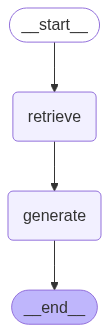

In [31]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Testing

In [42]:
from IPython.display import display, Markdown


def pretty_print_step(step):
    if step.get("retrieve"):
        context = step["retrieve"]["context"]
        retrieved_docs = [doc.metadata["source"] for doc in context]
        print(f"Retrieved docs: {retrieved_docs}")
    elif step.get("generate"):
        display(Markdown(step["generate"]["answer"]))
    else:
        print(step)

In [43]:
for step in graph.stream(
    {"question": "Who has the most number of albums"},
    stream_mode="updates",
):
    pretty_print_step(step)

Retrieved docs: ['embedding/album.txt', 'embedding/track.txt', 'embedding/artist.txt', 'embedding/database_summary.txt']


```sql
SELECT a.ArtistId, ar.Name, COUNT(a.AlbumId) AS AlbumCount
FROM albums a
JOIN artists ar ON a.ArtistId = ar.ArtistId
GROUP BY a.ArtistId, ar.Name
ORDER BY AlbumCount DESC
LIMIT 5;
```

In [44]:
for step in graph.stream(
    {
        "question": "How many tracks have composer 'Angus Young, Malcolm Young, Brian Johnson'"
    },
    stream_mode="updates",
):
    pretty_print_step(step)

Retrieved docs: ['embedding/track.txt', 'embedding/album.txt', 'embedding/playlist_track.txt', 'embedding/artist.txt']


```sql
SELECT COUNT(*) AS TrackCount 
FROM tracks 
WHERE Composer = 'Angus Young, Malcolm Young, Brian Johnson';
```

In [45]:
for step in graph.stream(
    {"question": "Which composers's tracks have generated over $100 in total sales?"},
    stream_mode="updates",
):
    pretty_print_step(step)

Retrieved docs: ['embedding/track.txt', 'embedding/invoice_line.txt', 'embedding/playlist_track.txt', 'embedding/database_summary.txt']


```sql
SELECT composer, SUM(il.UnitPrice * il.Quantity) AS total_sales
FROM InvoiceLine il
JOIN tracks t ON il.TrackId = t.TrackId
GROUP BY composer
HAVING total_sales > 100
ORDER BY total_sales DESC
LIMIT 5;
```